## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

## Exploratory Data Analysis

In [2]:
# Reading the dataset
data = pd.read_csv('2010-capitalbikeshare-tripdata.csv')

In [5]:
# checking for null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115597 entries, 0 to 115596
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Duration              115597 non-null  int64 
 1   Start date            115597 non-null  object
 2   End date              115597 non-null  object
 3   Start station number  115597 non-null  int64 
 4   Start station         115597 non-null  object
 5   End station number    115597 non-null  int64 
 6   End station           115597 non-null  object
 7   Bike number           115597 non-null  object
 8   Member type           115597 non-null  object
dtypes: int64(3), object(6)
memory usage: 7.9+ MB


* There are no null values in any of the features.

In [6]:
# analysing numerical data
data.describe()

,Duration,Start station number,End station number
count,115597.000000,115597.000000,115597.000000
mean,1254.649956,31266.213431,31268.042250
std,2914.317998,187.645048,186.194316
min,60.000000,31000.000000,31000.000000
25%,403.000000,31110.000000,31111.000000
50%,665.000000,31213.000000,31214.000000
75%,1120.000000,31301.000000,31238.000000
max,85644.000000,31805.000000,31805.000000


* Average duration for a trip is 1254 seconds, i.e., around 21 minutes.
* 50th percentile value for duration is 665 seconds, i.e., around 11 minutes, this shows that we have outliers in our dataset.

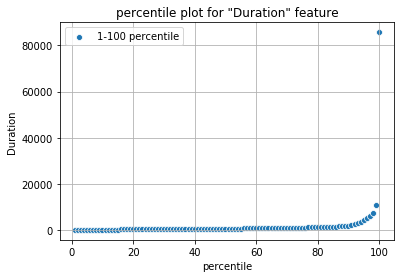

In [4]:
# Plotting the percentiles for "Duration" feature to find out outliers

percentile = []
for i in range(100):
    percentile.append(np.percentile(data['Duration'], i+1))

sns.scatterplot(list(np.arange(1, 101)), percentile, label = '1-100 percentile')
plt.title('percentile plot for "Duration" feature')
plt.xlabel('percentile')
plt.ylabel('Duration')
plt.grid()
plt.legend()
plt.show()

* As we can see that values upto 90 percentile are less and then values are increasing exponentially.
* Now, I will zoom into 90-100 percentile to detect for outliers.

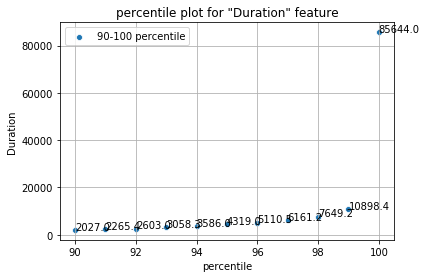

In [5]:
# plotting 90-100th percentile

sns.scatterplot(list(np.arange(90, 101)), percentile[89:], label = '90-100 percentile') # indexing of a list starts from zero
# annotating each point with "Duration" value
for i, pt in enumerate(percentile[89:]):
    plt.annotate(np.round(pt, 1), xy = (i+90, pt))
    
plt.title('percentile plot for "Duration" feature')
plt.xlabel('percentile')
plt.ylabel('Duration')
plt.grid()
plt.legend()
plt.show()

* 99th percentile value is around 10898 seconds, which is around 180 minutes or 3 hours, which seems acceptable.
* We will further narrow down our analysis between 99 and 100th percentile.

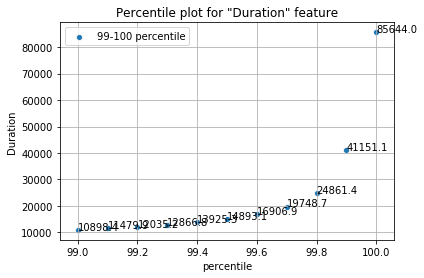

In [6]:
# plotting percentile values between 99 and 100 percentile

zoom_percentile = []
for i in np.arange(99, 100.1, 0.1):
    zoom_percentile.append(np.percentile(data['Duration'], np.round(i, 1)))

sns.scatterplot(list(np.round(np.arange(99, 100.1, 0.1), 1)), zoom_percentile, label = '99-100 percentile')
# annotating the "Duration" values
for i, pt in enumerate(zoom_percentile):
    plt.annotate(np.round(pt, 1), xy = (list(np.round(np.arange(99, 100.1, 0.1), 1))[i], pt))
    
plt.title('Percentile plot for "Duration" feature')
plt.xlabel('percentile')
plt.ylabel('Duration')
plt.grid()
plt.legend()
plt.show()

* We can see the inflection point at 99.8 percentile, which has a "Duration" value of around 24861. We can ignore the values above this as outliers.

In [3]:
# Filtering out data above 99.8 percentile as per duration column and removing them

filt = data['Duration'] > 24861.4
data.drop(data.loc[filt].index, axis = 'index', inplace = True)

In [4]:
# checking for class imbalance 

class_distb = data['Member type'].value_counts()
print(class_distb)
print('Percentage of points belonging to "Member" class is: ', class_distb['Member']/class_distb.sum())
print('Percentage of points belonging to "Casual" class is: ', class_distb['Casual']/class_distb.sum())
print('Percentage of points belonging to "Unknown" class is: ', class_distb['Unknown']/class_distb.sum())

Member     91532
Casual     23823
Unknown       10
Name: Member type, dtype: int64
Percentage of points belonging to "Member" class is:  0.793412213409613
Percentage of points belonging to "Casual" class is:  0.20650110518788195
Percentage of points belonging to "Unknown" class is:  8.668140250509253e-05


* I can remove the data points belonging to "Unknown" class.
* There is a huge imbalance in the dataset in 80:20 ratio.

In [4]:
# removing rows with "Unknown" class label

filt = data['Member type'] == 'Unknown'
data.drop(data.loc[filt, 'Member type'].index, axis = 'index', inplace = True)

In [31]:
# Travelling duration difference between different types of members

data.groupby('Member type')['Duration'].median()

Member type
Casual    1511
Member     580
Name: Duration, dtype: int64

* We can see that "Casual" members usually take long duration trips as compared to registered members.
* This may be due to the fact that registered members are ones who are daily users and "Casual" members take the ride for special purposes.

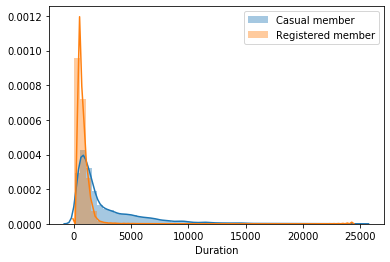

In [41]:
# distribution plot of "Duration" category for each class label

sns.distplot(data.loc[data.groupby('Member type').groups['Casual'], 'Duration'], label = 'Casual member')
sns.distplot(data.loc[data.groupby('Member type').groups['Member'], 'Duration'], label = 'Registered member')
plt.legend()
plt.title('Distribution of Duration for each type of member/user')
plt.show()

* We can see that registered members tend to take short duration trips.
* Casual members while taking shorter trips also tends to take long duration trips more often than Registered members.

In [5]:
# compiling the pattern of the date-time to extract only the time in hours and minutes

date_pattern = re.compile(r'\d{4}-\d{2}-\d{2}\s(\d+):(\d+):\d+')

In [6]:
# extracting the time information from datetime column

time = []
for t in data['Start date']:
    time.append(re.sub(date_pattern, r'\1', t))
    
# appending the time column to our dataframe
data['timings'] = time

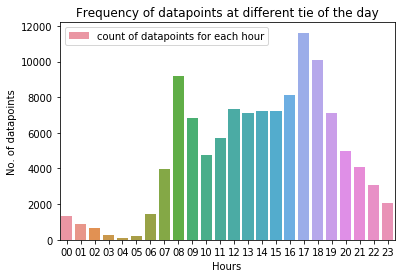

In [140]:
# Plotting the bar chart for the frequency of users at various timings of the day

sns.barplot(x = data.groupby(by = 'timings')['Member type'].count().index, y = data.groupby(by = 'timings')['Member type'].count(), label = 'count of datapoints for each hour')
plt.xlabel('Hours')
plt.ylabel('No. of datapoints')
plt.title('Frequency of datapoints at different tie of the day')
plt.legend()
plt.show()

* We can see that there is a spike at around 8am, this may be due to people going to office.
* Another spike can be seen at around 5pm and 6pm, this is when people leave their office.
* Clearly, at some points of the day, the number of users taking bike increases. This is probably because of the office timings.

In [78]:
# finding the frequency distribution of bike usage for each member type individually at various timings

filt = data.groupby(by = 'Member type')

member_timings = data.loc[filt.groups['Member'], 'timings'].value_counts()

casual_timings = data.loc[filt.groups['Casual'], 'timings'].value_counts()

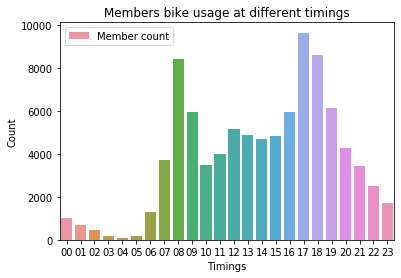

In [114]:
# plotting the usage of bikes by members at different timings

sns.barplot(member_timings.index, member_timings,label = 'Member count')
plt.title('Members bike usage at different timings')
plt.xlabel('Timings')
plt.ylabel('Count')
plt.legend()
plt.show()

* Top five timings are 5pm, 6pm, 8am, 7pm and 4pm.
* Clearly top timings corresponds to the office going and office leaving time.

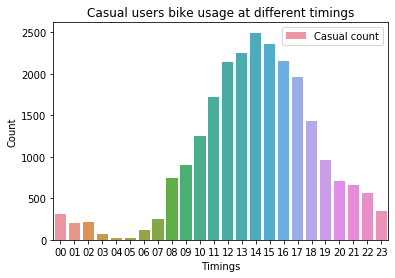

In [112]:
# plotting the usage of bikes by casual users at different timings

sns.barplot(casual_timings.index, casual_timings,label = 'Casual count')
plt.title('Casual users bike usage at different timings')
plt.xlabel('Timings')
plt.ylabel('Count')
plt.legend()
plt.show()

* Top five timings are 2pm, 3pm, 1pm, 4pm and 12pm.
* clearly, top timings are in the afternoon, when users do their daily routine work.

In [7]:
# compiling the date pattern to extract date and month

date_pattern = re.compile(r'\d{4}-(\d{2})-(\d{2})\s\d{2}:\d{2}:\d{2}')

date = []
for d in data['Start date']:
    date.append(re.sub(date_pattern, r'\1\2', d))
    
data['date'] = date

In [114]:
# date wise distribution of 'Member' class

filt = data.groupby(by = 'Member type')

member_date = data.loc[filt.groups['Member'], 'date'].value_counts()

casual_date = data.loc[filt.groups['Casual'], 'date'].value_counts()

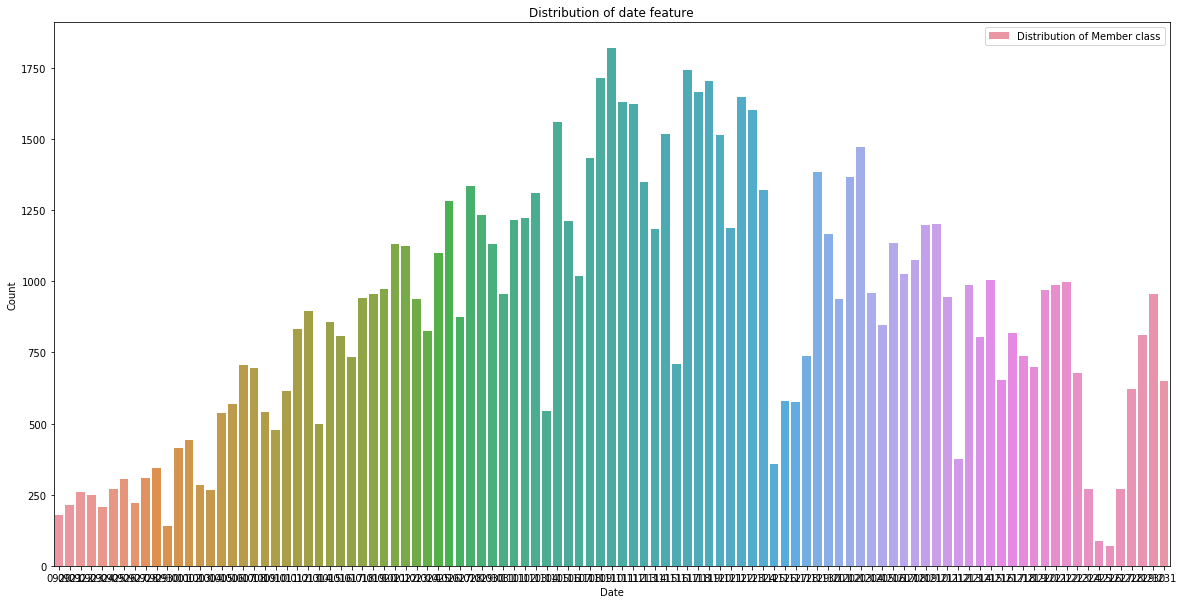

In [141]:
# plotting the distribution of date feature for 'Member' class

plt.figure(figsize = (20,10))
sns.barplot(member_date.index, member_date, label = 'Distribution of Member class')
plt.title('Distribution of date feature')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

* As we can see that users of member class uses the bike, the most in the 11th month.
* In each month at some dates, the usage peaks and at some dates the usage decreases.

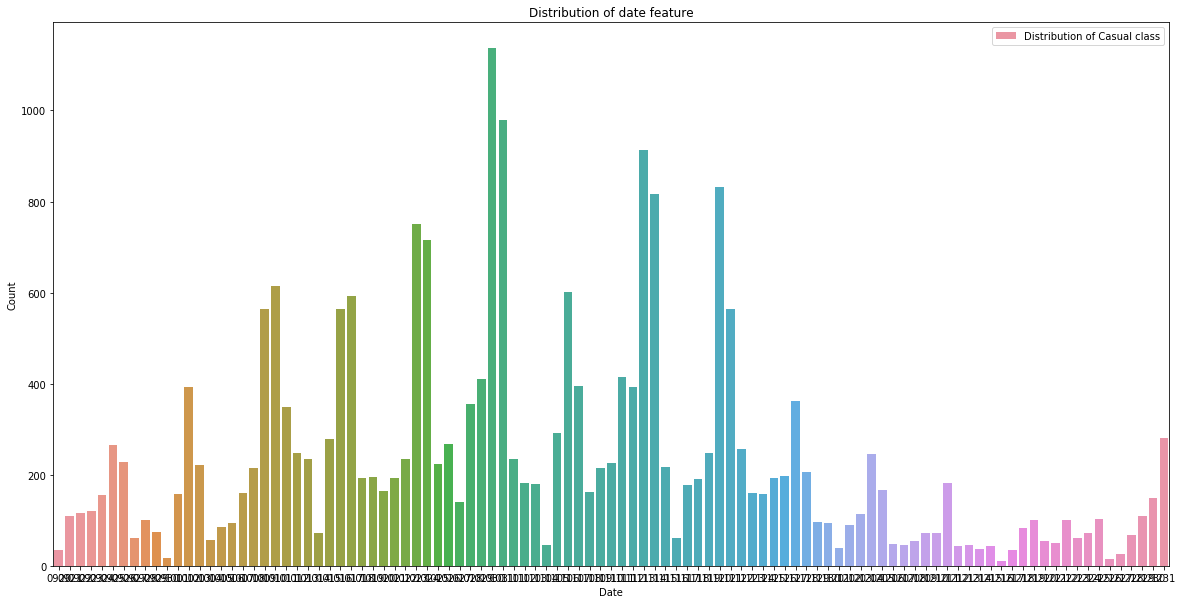

In [142]:
# plotting the distribution of date feature for 'Casual' class

plt.figure(figsize = (20,10))
sns.barplot(casual_date.index, casual_date,label = 'Distribution of Casual class')
plt.title('Distribution of date feature')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

* There is a repeating structure in the graph. People may be taking more bikes on weekends or the other way round.

In [ ]:
# Removing the start date and end date column
# data.drop(columns = ['Start date', 'End date'], inplace = True)

In [77]:
# Counting the number of stations

print('Start Station Unique count: ', data['Start station number'].unique().size)
print('End Station Unique count: ', data['End station number'].unique().size)

# Finding the stations that are not common between starting and ending station list
statn = []
for n in data['End station number'].unique():
    if n not in data['Start station number'].unique():
        statn.append(n)
        
print('\nIndex of the datapoint having a unique ending station', statn)

# Printing the unique station datapoint
filt = data['End station number'] == statn[0]
data.loc[filt]

Start Station Unique count:  106
End Station Unique count:  107

Index of the datapoint having a unique ending station [31262]


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type,timings,date
30997,1671,2010-10-26 18:58:09,2010-10-26 19:26:00,31228,8th & H St NW,31262,11th & F St NW,W00404,Member,18,1026


* We can see that there is one additional station in the ending station list, which is not in the starting station list.

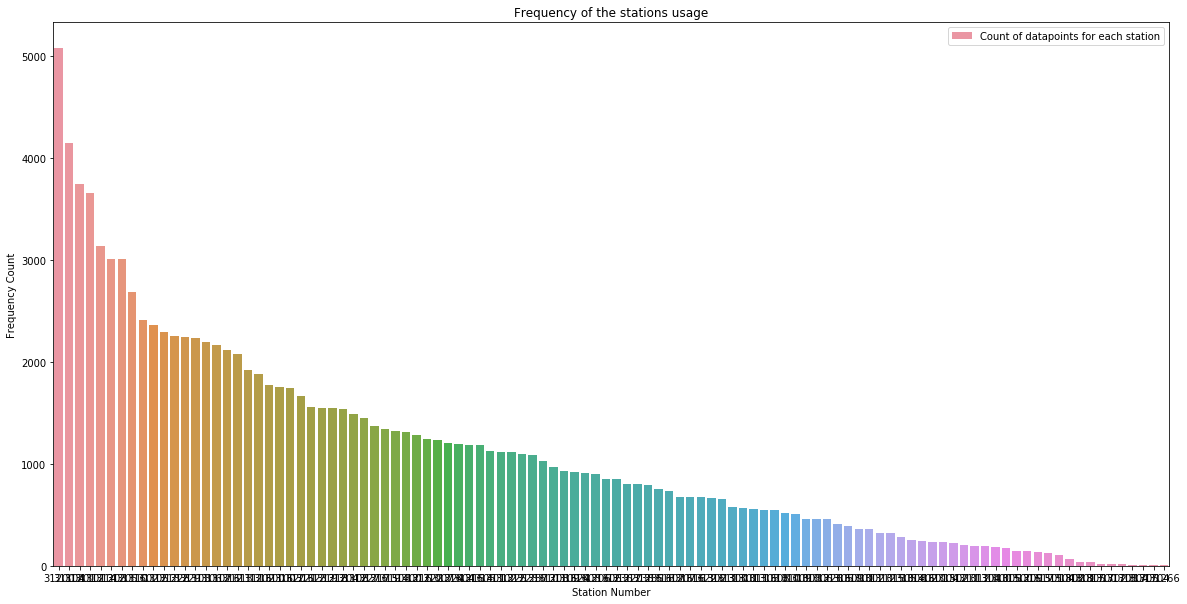

In [147]:
# Counting the number of datapoints belonging to a particular starting station

plt.figure(figsize = (20, 10))
sns.barplot(data['Start station number'].value_counts().index, data['Start station number'].value_counts(), order = data['Start station number'].value_counts().index, label = 'Count of datapoints for each station')
plt.title('Frequency of the stations usage')
plt.xlabel('Station Number')
plt.ylabel('Frequency Count')
plt.legend()
plt.show()

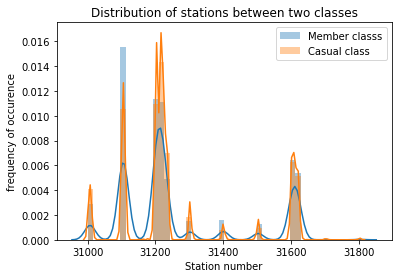

In [38]:
# frequency distribution of each class label for station feature

sns.distplot(data.loc[data.groupby(by = 'Member type').groups['Member'], 'Start station number'], label = 'Member classs')
sns.distplot(data.loc[data.groupby(by = 'Member type').groups['Casual'], 'Start station number'], label = 'Casual class')
plt.title('Distribution of stations between two classes')
plt.xlabel('Station number')
plt.ylabel('frequency of occurence')
plt.legend()
plt.show()

* Some stations are used more than others.
* Some are rarely used.

Number of unique bikes: 959


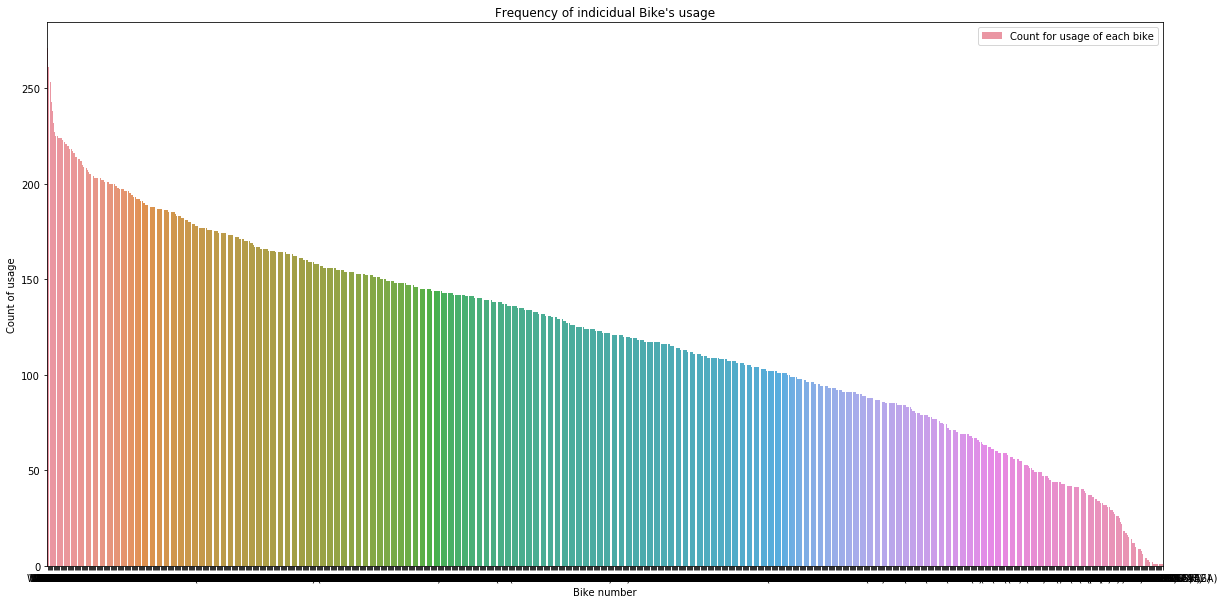

In [199]:
# Finding the distribution of usage of each unique bike

print('Number of unique bikes:', data['Bike number'].unique().size)
plt.figure(figsize = (20, 10))
sns.barplot(data['Bike number'].value_counts().index, data['Bike number'].value_counts(), label = 'Count of usage of each bike')
plt.title('Frequency of indicidual Bike\'s usage')
plt.xlabel('Bike number')
plt.ylabel('Count of usage')
plt.legend()
plt.show()

In [201]:
# searching for any inconsisent/error(typo) values
data['Bike number'].unique()

array(['W00742', 'W00032', 'W00993', 'W00344', 'W00883', 'W00850',
       'W00804', 'W01084', 'W00812', 'W00803', 'W00256', 'W01023',
       'W00472', 'W00685', 'W00930', 'W00476', 'W00955', 'W01066',
       'W00824', 'W01029', 'W00821', 'W00833', 'W01123', 'W01034',
       'W00796', 'W00764', 'W00868', 'W00775', 'W00570', 'W01103',
       'W01058', 'W01069', '?(0x000000004752DD3A)', 'W00977', 'W00960',
       'W00958', 'W00563', 'W00976', 'W00159', 'W00642', 'W00999',
       'W00842', 'W00745', 'W01079', '?(0x000000007C120F6A)', 'W00911',
       'W00322', 'W00829', 'W00814', 'W01113', 'W00569', 'W00428',
       'W01050', 'W00903', 'W00968', 'W01007', 'W00826', 'W00340',
       'W01024', 'W00830', 'W00196', 'W00512', 'W00377', 'W00747',
       'W00142', 'W00777', 'W00614', 'W00795', 'W00289', 'W00735',
       'W01059', 'W01016', 'W00872', 'W00758', 'W00605', 'W00772',
       'W00318', 'W00928', 'W00867', 'W00380', 'W01008', 'W00819',
       'W00194', 'W00873', 'W00973', 'W00961', 'W010

* We can see that there are some bike numbers which are incorrect/typos. We can count and correct them.

In [252]:
# Finding the indexes which are not available/missing

incorrect_idx = []
for i, d in enumerate(data['Member type']):
    try:
        data.loc[i, 'Member type']
    except:
        incorrect_idx.append(i)

In [255]:
# total number of missing indexes
len(incorrect_idx)

241

In [8]:
# compiling the regular expression for correct bike names
bike_num = re.compile(r'\w\d{5}$')

In [9]:
# replacing the missing values with most frequent values for that class label

for i in data.index:
    
    if re.search(bike_num, data['Bike number'][i]):
        continue
        
    else:
        # replacing the typo/incorrect bike number with the most frequent bike number at that particular station
        stn_num = data.loc[i, 'Start station number']
        filt = data['Start station number'] == stn_num
        new_bikenum = data.loc[filt, 'Bike number'].value_counts().index[0]
        data['Bike number'][i] = new_bikenum

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [11]:
# Response coding the bike number feature

tot_cnt = data['Bike number'].value_counts()
mem_cnt = data.loc[data.groupby(by = 'Member type').groups['Member'], 'Bike number'].value_counts()

res_coding = 0
for n in tot_cnt.index:
    
    if n in mem_cnt:
        # calculating the probability value for this bike number for 'Member' class
        res_coding = mem_cnt[n]/tot_cnt[n]
        
        filt = data['Bike number'] == n # for all the datapoints having this bike number put the response coded value inplace of bike number
        data.loc[filt, 'Bike number'] = res_coding
        
    else:
        # If the bike number is not found in 'Member' group, then appen zero as the probability for this bike number for 'Member' class will be zero
        filt = data['Bike number'] == n
        data.loc[filt, 'Bike number'] = 0

In [12]:
# Encoding class labels into binary values

bin_enc = []
for label in data['Member type']:
    if label == 'Member':
        bin_enc.append(1)
    elif label == 'Casual':
        bin_enc.append(0)
        
# creating a new column in the dataframe with binary class labels
data['Member'] = bin_enc

In [13]:
# Creating new features
statn_comb = data['Start station number'] + data['End station number']
data['statn_comb'] = statn_comb

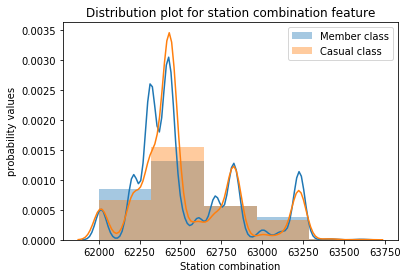

In [22]:
# plotting the distribution of the station combination feature for each class label

sns.distplot(data.loc[data['Member type'] == 'Member', 'statn_comb'], label = 'Member class', bins = 5)
sns.distplot(data.loc[data['Member type'] == 'Casual', 'statn_comb'], label = 'Casual class', bins = 5)
plt.title('Distribution plot for station combination feature')
plt.xlabel('Station combination')
plt.ylabel('probability values')
plt.legend()
plt.show()

* This feature seems useful as there are some areas ehich are not overlapping.

## Data Preprocessing

In [39]:
# dropping the already processed features
data.drop(columns = ['Start date', 'End date', 'Member type'], inplace = True)

In [41]:
# separating the class label from the dataframe

y = data['Member']
data.drop(columns = ['Member', 'Start station', 'End station'], inplace = True)

In [96]:
# splitting the data into train and test in 70:30 ratio

xtrain, xtest, ytrain, ytest = train_test_split(data, y, test_size = 0.3, stratify = y)

In [52]:
# Creating a vocabulary of all the unique station numbers in training data

vocab1 = {n for n in xtrain['End station number']}
vocab2 = {n for n in xtrain['Start station number']}
statn_vocab = vocab1.union(vocab2)

In [58]:
# One Hot Encoding(OHE) the station number feature

vec = CountVectorizer(vocabulary = statn_vocab, lowercase = False)

tr_endstat_num = vec.transform(xtrain['End station number'].astype(str))
tr_startstat_num = vec.transform(xtrain['Start station number'].astype(str))
te_endstat_num = vec.transform(xtest['End station number'].astype(str))
te_startstat_num = vec.transform(xtest['Start station number'].astype(str))

In [68]:
# scaling the duration feature in 0-1 range

scaler = MinMaxScaler()
tr_dur = scaler.fit_transform(np.array(xtrain['Duration']).reshape(-1, 1))
te_dur = scaler.transform(np.array(xtest['Duration']).reshape(-1, 1))

In [70]:
# scaling the timings feature in 0-1 range

scaler = MinMaxScaler()
tr_time = scaler.fit_transform(np.array(xtrain['timings']).reshape(-1, 1))
te_time = scaler.transform(np.array(xtest['timings']).reshape(-1, 1))

In [71]:
# scaling the date feature in 0-1 range

scaler = MinMaxScaler()
tr_date = scaler.fit_transform(np.array(xtrain['date']).reshape(-1, 1))
te_date = scaler.transform(np.array(xtest['date']).reshape(-1, 1))

In [72]:
# scaling the statn_comb feature in 0-1 range

scaler = MinMaxScaler()
tr_comb = scaler.fit_transform(np.array(xtrain['statn_comb']).reshape(-1, 1))
te_comb = scaler.transform(np.array(xtest['statn_comb']).reshape(-1, 1))

In [ ]:
# storing bike number feature in a variable to be used in stacking data

# converting to dtype(float) as dtype(object) is not supported in hstack
tr_bikenum = np.array(xtrain['Bike number'].astype(float)).reshape(-1, 1)
te_bikenum = np.array(xtest['Bike number'].astype(float)).reshape(-1, 1)

## Data Modelling

In [106]:
# stacking the data horizontally to use in machine learning models

xtrain = hstack((tr_endstat_num, tr_startstat_num, tr_dur, tr_time, tr_date, tr_comb, tr_bikenum))
xtest = hstack((te_endstat_num, te_startstat_num, te_dur, te_time, te_date, te_comb, te_bikenum))

print(xtrain.shape)
print(xtest.shape)

(80748, 219)
(34607, 219)


### K Nearest Neighbor(KNN)

In [121]:
# Finding the best hyperparameter using GridSearchCV

knn = KNeighborsClassifier()

params = dict(n_neighbors = [5, 10, 20, 40, 80, 160, 320])

grid = GridSearchCV(estimator = knn, cv = 2, scoring = 'roc_auc', param_grid = params, return_train_score = True)
grid.fit(xtrain, ytrain)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [5, 10, 20, 40, 80, 160, 320]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

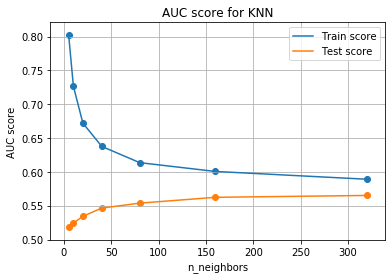

In [126]:
# plotting the result

plt.plot(params['n_neighbors'], grid.cv_results_['mean_train_score'], label = 'Train score')
plt.plot(params['n_neighbors'], grid.cv_results_['mean_test_score'], label = 'Test score')
plt.scatter(params['n_neighbors'], grid.cv_results_['mean_train_score'])
plt.scatter(params['n_neighbors'], grid.cv_results_['mean_test_score'])
plt.title('AUC score for KNN')
plt.xlabel('n_neighbors')
plt.ylabel('AUC score')
plt.legend()
plt.grid()
plt.show()

In [128]:
# training the model with optimal hyperparmeter
knn = KNeighborsClassifier(n_neighbors = 360)
knn.fit(xtrain, ytrain)

knn.score(xtest, ytest)

0.7934810876412286

### Logistic Regression(LR)

In [ ]:
# Finding the optimal hyperparameter using GridSearchCV

lr = LogisticRegressionClassifier()

params = dict(alpha = [])

grid = GridSearchCV(estimator = lr, cv = 2, scoring = 'roc_auc', return_train_score = True, param_grid = params)
grid.fit(xtrain, ytrain)

In [ ]:
# Plotting the hyperparameter vs AUC score 

plt.scatter(params['alpha'], grid.cv_results_['mean_train_score'], label = 'Train AUC score')
plt.scatter(params['alpha'], grid.cv_results_['mean_test_score'], label = 'Test AUC score')
plt.title('AUC score for Logistic Regression')
plt.xlabel('alpha')
plt.ylabel('AUC score')
plt.legend()
plt.grid()
plt.show()

## Summary

In [ ]:
# Summarizing the results using in tabular form using prettytable

pt = PrettyTable()

pt.field_names(['Classifier', 'Optimal Hyperparameter', 'ROC Score'])
pt.add_row(['KNN', 'k = 160', ''])
print(pt)